In [61]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

In [62]:
csv_path = Path("RawData/gemini_BTCUSD_1hr.csv")
btc_df = pd.read_csv(csv_path, parse_dates=True, index_col='Date', infer_datetime_format=True)
btc_df = btc_df.sort_index()
btc_df.tail()

,Unix Timestamp,Symbol,Open,High,Low,Close,Volume
Date,,,,,,,
2021-01-14 20:00:00,1.610650e+12,BTCUSD,39885.61,39911.00,39305.21,39336.89,52.909791
2021-01-14 21:00:00,1.610660e+12,BTCUSD,39336.89,39453.97,38220.00,38773.68,181.618546
2021-01-14 22:00:00,1.610660e+12,BTCUSD,38773.68,39089.94,38361.00,38981.41,92.893830
2021-01-14 23:00:00,1.610670e+12,BTCUSD,38981.41,39283.60,38746.00,39147.75,57.506068
2021-01-15 00:00:00,1.610670e+12,BTCUSD,39147.75,39443.67,39017.72,39443.67,9.715842


<AxesSubplot:title={'center':'BTC Price'}, xlabel='Date'>

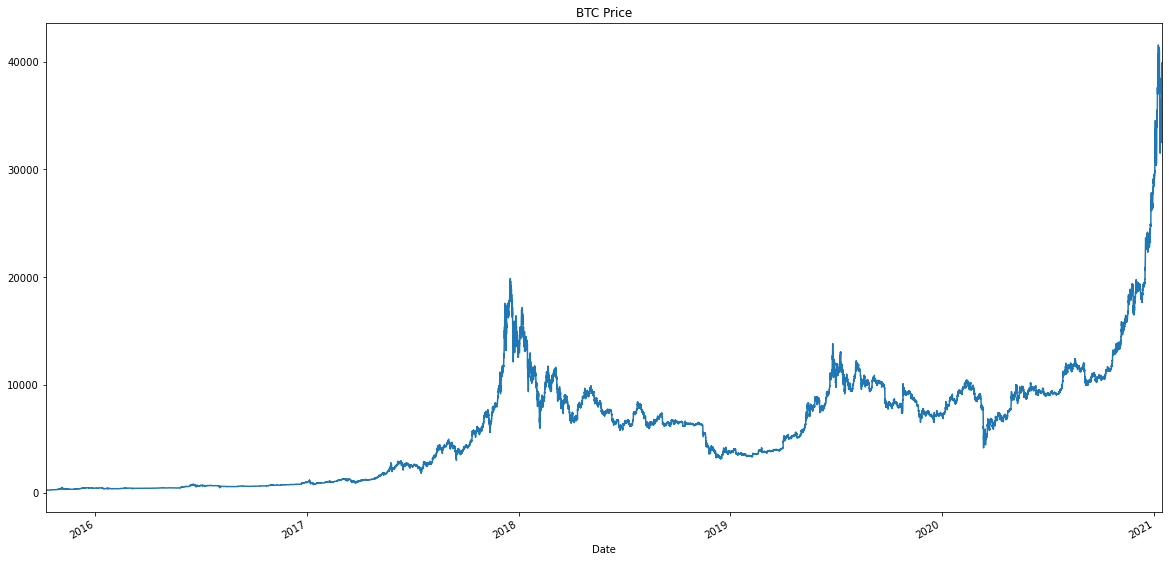

In [63]:
btc_df.Close.plot(title="BTC Price", figsize=(20,10))

In [64]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Close" price into two separate series:
y_noise, y_trend = sm.tsa.filters.hpfilter(btc_df['Close'])

In [65]:
#Create a dataframe of just the Closing price, and add columns for "noise" and "trend" series from above: (Part 2)
btc_df['Noise'] = y_noise
btc_df['Trend'] = y_trend
btc_df.tail()

,Unix Timestamp,Symbol,Open,High,Low,Close,Volume,Noise,Trend
Date,,,,,,,,,
2021-01-14 20:00:00,1.610650e+12,BTCUSD,39885.61,39911.00,39305.21,39336.89,52.909791,-46.838524,39383.728524
2021-01-14 21:00:00,1.610660e+12,BTCUSD,39336.89,39453.97,38220.00,38773.68,181.618546,-678.125045,39451.805045
2021-01-14 22:00:00,1.610660e+12,BTCUSD,38773.68,39089.94,38361.00,38981.41,92.893830,-537.200603,39518.610603
2021-01-14 23:00:00,1.610670e+12,BTCUSD,38981.41,39283.60,38746.00,39147.75,57.506068,-437.133757,39584.883757
2021-01-15 00:00:00,1.610670e+12,BTCUSD,39147.75,39443.67,39017.72,39443.67,9.715842,-207.357312,39651.027312


<AxesSubplot:xlabel='Date'>

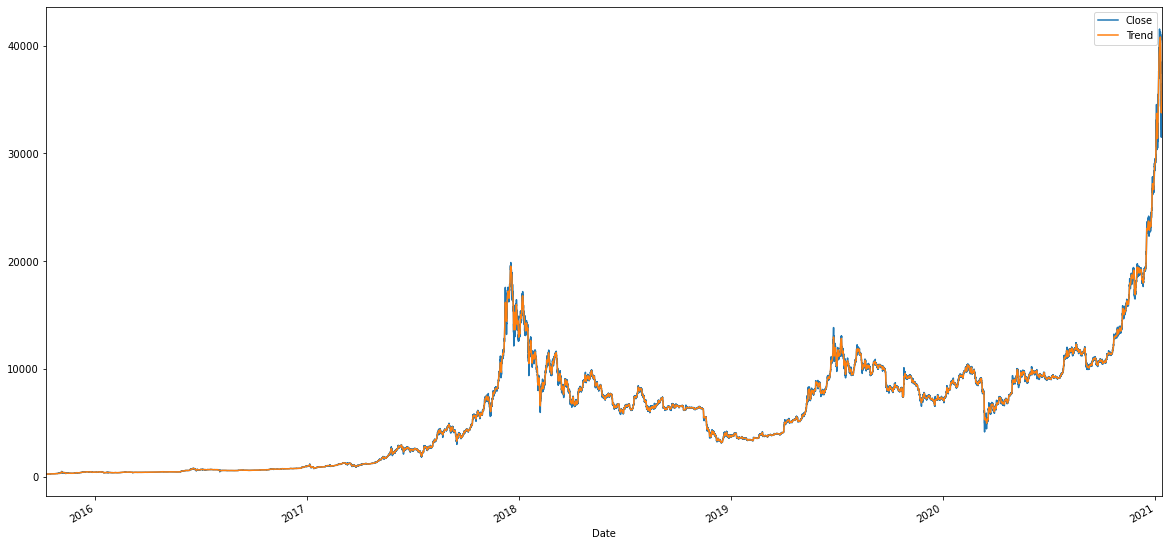

In [66]:
# Plot the Close Price vs. the Trend for 2016 to the present
btc_chart = btc_df[['Close', 'Trend']]
btc_chart.loc['2015':"2021-01-12"].plot(figsize=(20,10))

<AxesSubplot:xlabel='Date'>

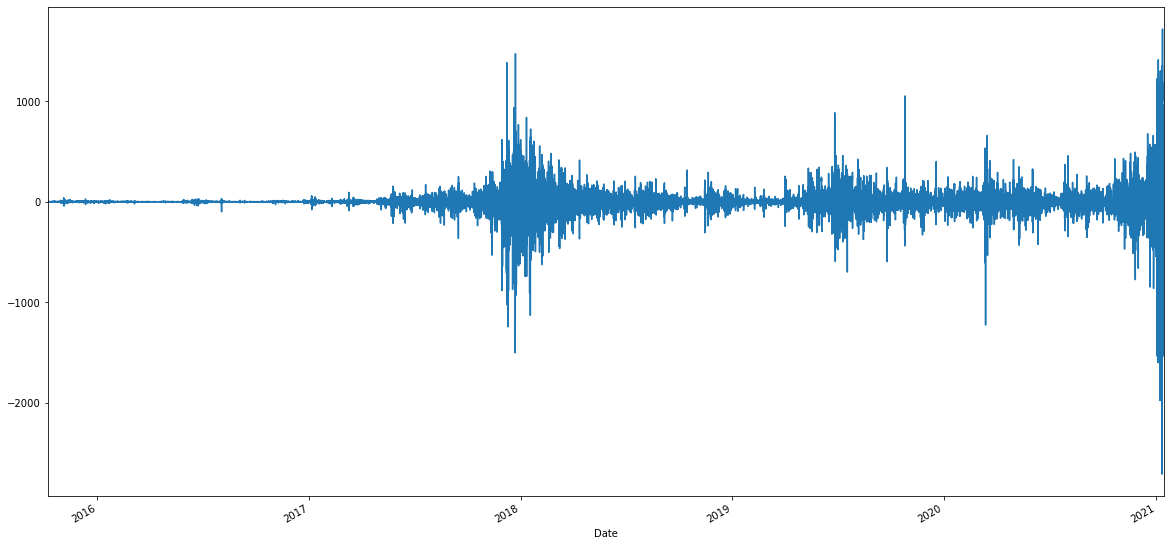

In [67]:
# Plot the Close Noise
y_noise.plot(figsize=(20,10))

In [68]:
# Create a series using "Close" price percentage returns, drop any nan"s, and check the results:
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (btc_df[["Close"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Close
Date,
2021-01-14 20:00:00,-1.375734
2021-01-14 21:00:00,-1.431760
2021-01-14 22:00:00,0.535750
2021-01-14 23:00:00,0.426716
2021-01-15 00:00:00,0.755906


# ARMA

In [69]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(returns.values, order=(2, 1))

# Fit the model and assign it to a variable called results
results = model.fit()

C:\Users\aafza\anaconda3\envs\pyvizenv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [70]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                46208
Model:                     ARMA(2, 1)   Log Likelihood              -59785.388
Method:                       css-mle   S.D. of innovations              0.882
Date:                Mon, 18 Jan 2021   AIC                         119580.776
Time:                        21:36:04   BIC                         119624.480
Sample:                             0   HQIC                        119594.516
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0149      0.004      4.076      0.000       0.008       0.022
ar.L1.y        0.3783      0.097      3.883      0.000       0.187       0.569
ar.L2.y       -0.0138      0.008     -1.636      0.102      -0.030       0.003
ma.L1.y       -0.4336      0.097     -4.452      0.000      -0.624      -0.243
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.9627           +0.0000j            2.9627            0.0000
AR.2           24.5078           +0.0000j           24.5078            0.0000
MA.1            2.3063           +0.0000j            2.3063            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'24 Hrs Returns Forecast'}>

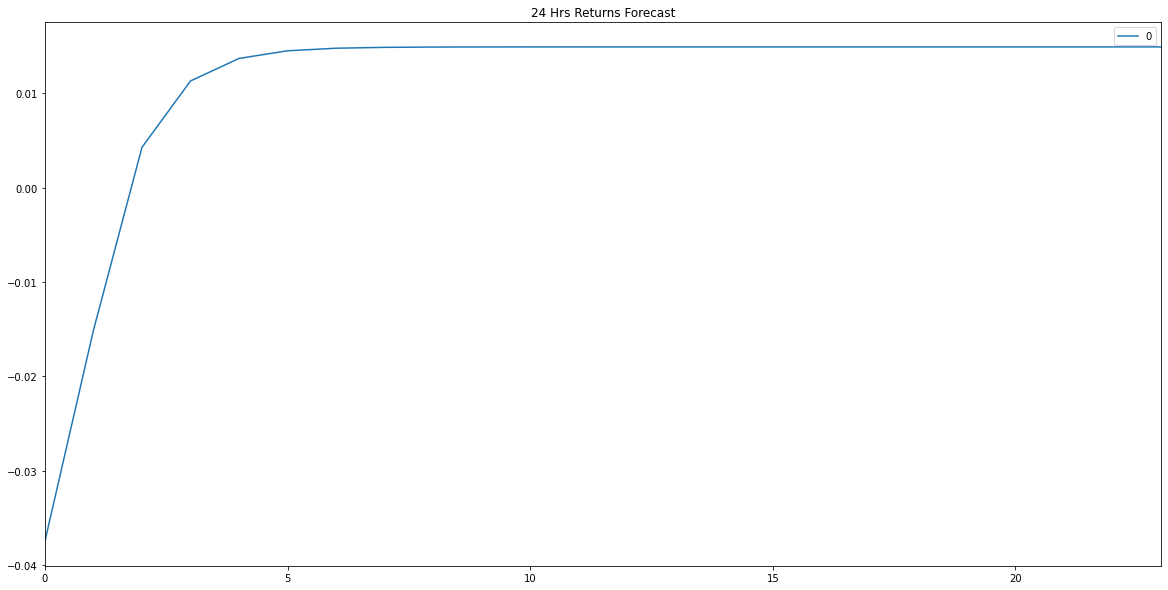

In [71]:
# Plot the 24 hrs Returns Forecast
pd.DataFrame(results.forecast(steps=24)[0]).plot(title="24 Hrs Returns Forecast", figsize=(20,10))

# ARIMA

In [72]:
from statsmodels.tsa.arima_model import ARIMA

In [73]:
# Estimate and ARIMA Model:
# ARIMA(df, order=(p, d, q))
model = ARIMA(btc_df.Close, order=(5,1,1))

# Fit the model
results = model.fit()

C:\Users\aafza\anaconda3\envs\pyvizenv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\aafza\anaconda3\envs\pyvizenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it

In [74]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                46208
Model:                 ARIMA(5, 1, 1)   Log Likelihood             -271410.411
Method:                       css-mle   S.D. of innovations             86.033
Date:                Mon, 18 Jan 2021   AIC                         542836.821
Time:                        21:37:35   BIC                         542906.748
Sample:                             1   HQIC                        542858.806
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.8477      0.356      2.380      0.017       0.150       1.546
ar.L1.D.Close    -0.3993      0.132     -3.025      0.002      -0.658      -0.141
ar.L2.D.Close    -0.0473      0.008     -6.140      0.000      -0.062      -0.032
ar.L3.D.Close    -0.0214      0.006     -3.297      0.001      -0.034      -0.009
ar.L4.D.Close    -0.0293      0.005     -5.675      0.000      -0.039      -0.019
ar.L5.D.Close    -0.0245      0.005     -4.632      0.000      -0.035      -0.014
ma.L1.D.Close     0.3546      0.132      2.686      0.007       0.096       0.613
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5108           -1.5768j            2.1838           -0.1284
AR.2            1.5108           +1.5768j            2.1838            0.1284
AR.3           -1.1436           -1.7688j            2.1063           -0.3413
AR.4           -1.1436           +1.7688j            2.1063            0.3413
AR.5           -1.9326           -0.0000j            1.9326           -0.5000
MA.1           -2.8203           +0.0000j            2.8203            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'24 Hours Price Forcast'}>

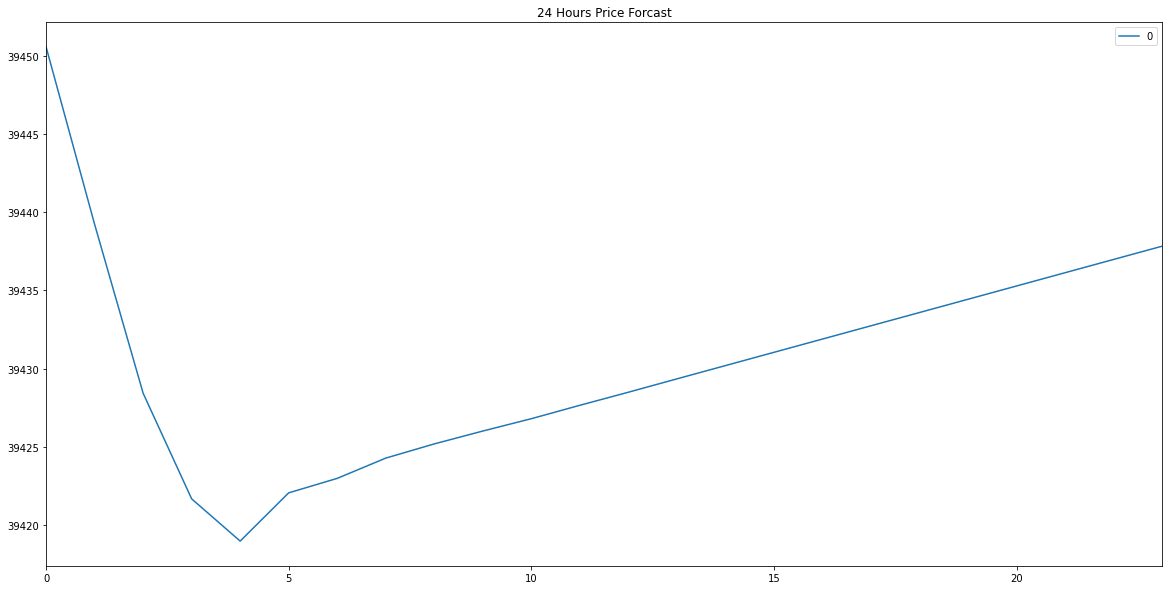

In [75]:
# Plot the 24 Hrs Price Forecast
pd.DataFrame(results.forecast(steps=24)[0]).plot(title='24 Hours Price Forcast', figsize=(20,10))

# GARCH

In [76]:
import arch as arch
from arch import arch_model

In [77]:
# Estimate a GARCH model:
model = arch_model(returns, mean='Zero', vol='GARCH', p=2, q=1)

# Fit the model
garch_results = model.fit(disp='off')

In [78]:
# Summarize the model results
garch_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -46145.8
Distribution:                  Normal   AIC:                           92299.6
Method:            Maximum Likelihood   BIC:                           92334.6
                                        No. Observations:                46208
Date:                Mon, Jan 18 2021   Df Residuals:                    46204
Time:                        21:37:40   Df Model:                            4
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      8.3654e-03  5.732e-03      1.459      0.144 [-2.870e-03,1.960e-02]
alpha[1]       0.1004  1.710e-02      5.873  4.290e-09    [6.689e-02,  0.134]
alpha[2]   1.4613e-08  5.014e-02  2.914e-07      1.000 [-9.828e-02,9.828e-02]
beta[1]        0.8996  4.012e-02     22.425 2.239e-111      [  0.821,  0.978]
=============================================================================

Covariance estimator: robust
"""

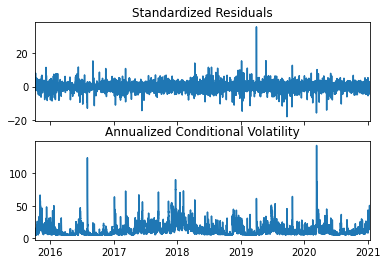

In [80]:
# Plot the model estimate of annualized volatility
fig = garch_results.plot(annualize='D')

In [84]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2021-01-15'

In [94]:
# Create a 3 day forecast of volatility
forecast_horizon = 24
# Start the forecast using the last_day calculated above
forecasts = garch_results.forecast(start='2021-01-15', horizon=forecast_horizon)

In [95]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10,...,h.15,h.16,h.17,h.18,h.19,h.20,h.21,h.22,h.23,h.24
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-15,17.296342,17.357253,17.417951,17.47844,17.53872,17.598794,17.658665,17.718334,17.777803,17.837074,...,18.130533,18.188658,18.246598,18.304356,18.361932,18.419329,18.476548,18.533591,18.59046,18.647155


In [96]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2021-01-15 00:00:00
h.01,17.296342
h.02,17.357253
h.03,17.417951
h.04,17.478440
h.05,17.538720


C:\Users\aafza\anaconda3\envs\pyvizenv\lib\site-packages\pandas\plotting\_core.py:396: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:title={'center':'24 Hrs Forecast of Volatility'}>

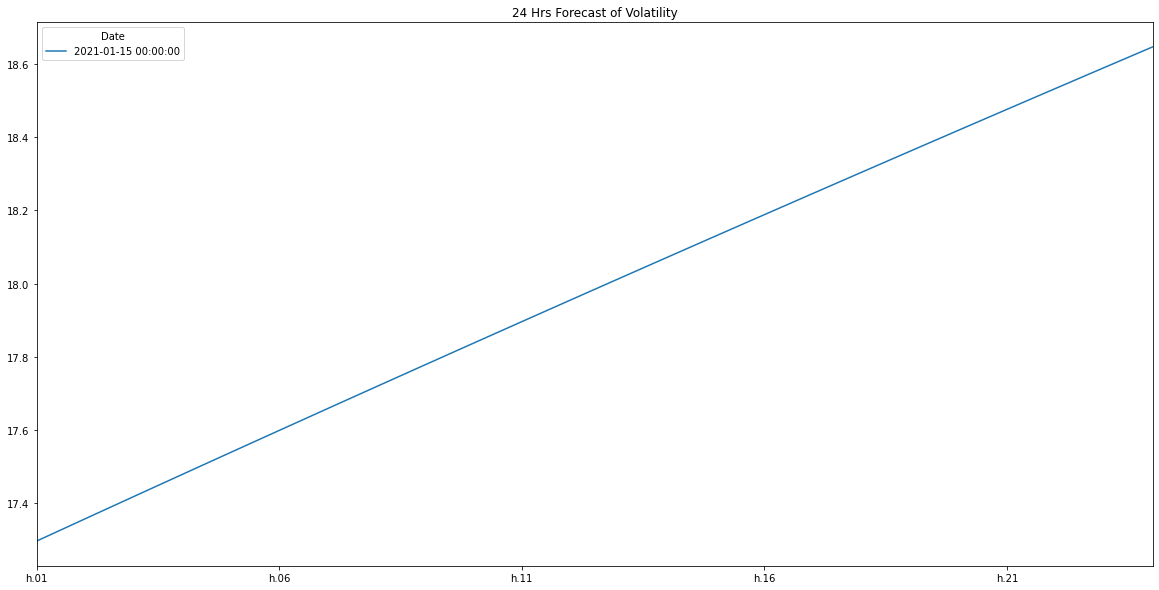

In [97]:
# Plot the final forecast
final.plot(title=('24 Hrs Forecast of Volatility'), figsize=(20,10))